In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_coherence import coherence_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline
import mne
import os
from configuration import base_folder

In [2]:
concat = []
for run_key in run_keys:
    concat.append(coherence_at_resp_job.get(run_key).to_dataframe())
coherence = pd.concat(concat)

coherence_at_resp is processing ('P12_baseline',)
coherence is processing ('P12_baseline',)
coherence_at_resp is processing ('P12_music',)
coherence is processing ('P12_music',)
coherence_at_resp is processing ('P12_odor',)
coherence is processing ('P12_odor',)


In [3]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [4]:
coherence = coherence.set_index(indexes).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])

In [5]:
coherence

,participant,session,chan,fmax_resp,max_resp,max_coherence,log_max_coherence
0,P01,baseline,Fp1,0.356259,882.435901,0.027298,-3.600945
1,P01,baseline,Fz,0.356259,882.435901,0.093940,-2.365099
2,P01,baseline,F3,0.356259,882.435901,0.080578,-2.518531
3,P01,baseline,F7,0.356259,882.435901,0.026322,-3.637365
4,P01,baseline,FT9,0.356259,882.435901,0.027211,-3.604137
...,...,...,...,...,...,...,...
1018,P12,odor,FC6,0.318758,2195.799213,0.619552,-0.478758
1019,P12,odor,FC2,0.318758,2195.799213,0.838979,-0.175569
1020,P12,odor,F4,0.318758,2195.799213,0.541073,-0.614202
1021,P12,odor,F8,0.318758,2195.799213,0.425412,-0.854698


In [6]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [7]:
coherence_baselined

,participant,session,chan,fmax_resp,max_resp,max_coherence,log_max_coherence
0,P01,odor,Fp1,0.0,-457.441046,-0.019530,-1.256856
1,P01,odor,Fz,0.0,-457.441046,-0.025588,-0.317985
2,P01,odor,F3,0.0,-457.441046,0.007871,0.093200
3,P01,odor,F7,0.0,-457.441046,-0.023718,-2.313502
4,P01,odor,FT9,0.0,-457.441046,-0.017519,-1.032374
...,...,...,...,...,...,...,...
677,P12,music,FC6,0.0,1475.198061,0.216050,0.824951
678,P12,music,FC2,0.0,1475.198061,-0.179670,-0.352246
679,P12,music,F4,0.0,1475.198061,0.012625,0.051621
680,P12,music,F8,0.0,1475.198061,0.102707,0.659888


/tmp/ipykernel_3089760/3824715237.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

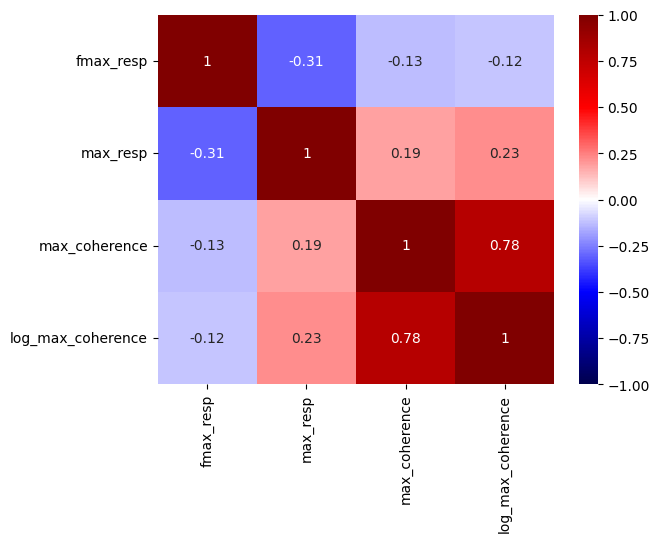

In [8]:
sns.heatmap(coherence.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

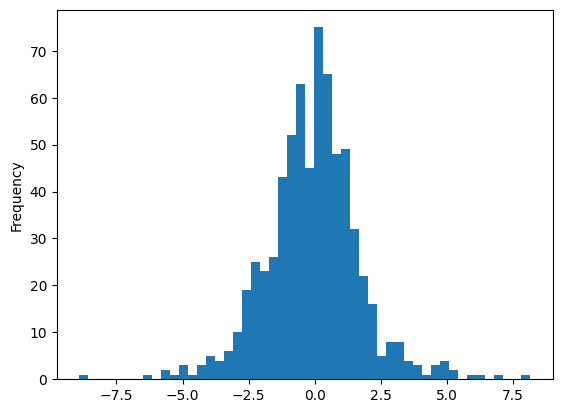

In [9]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

In [10]:
pos = get_pos()

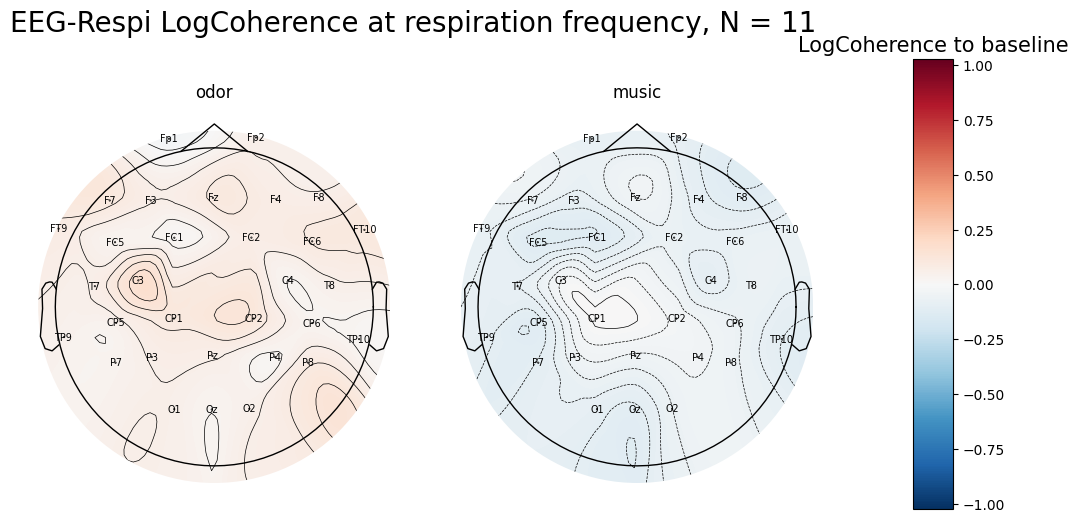

In [11]:
q_diff = 0.

df = coherence_baselined

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)['log_max_coherence'].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogCoherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'log_coherence_substract_baseline.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

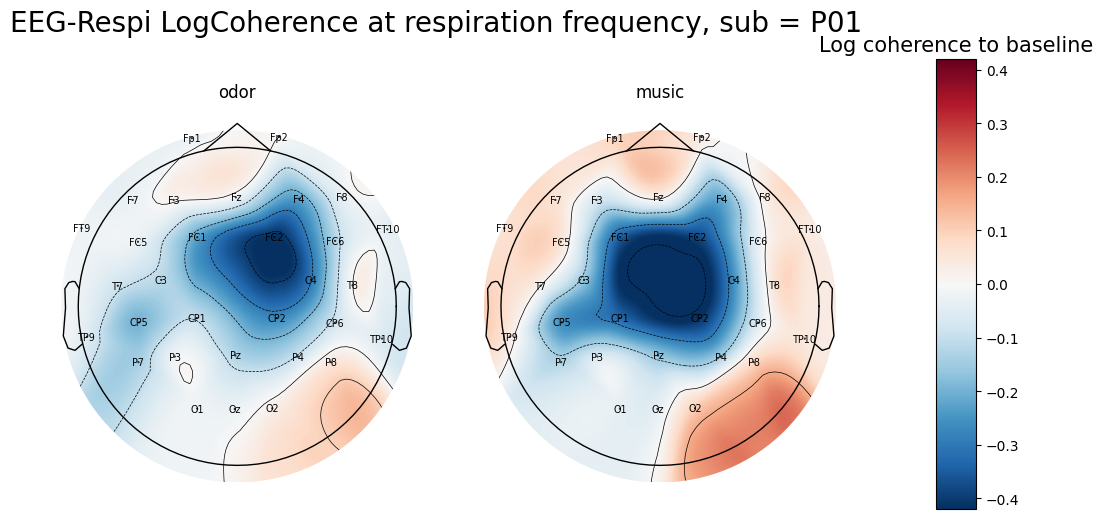

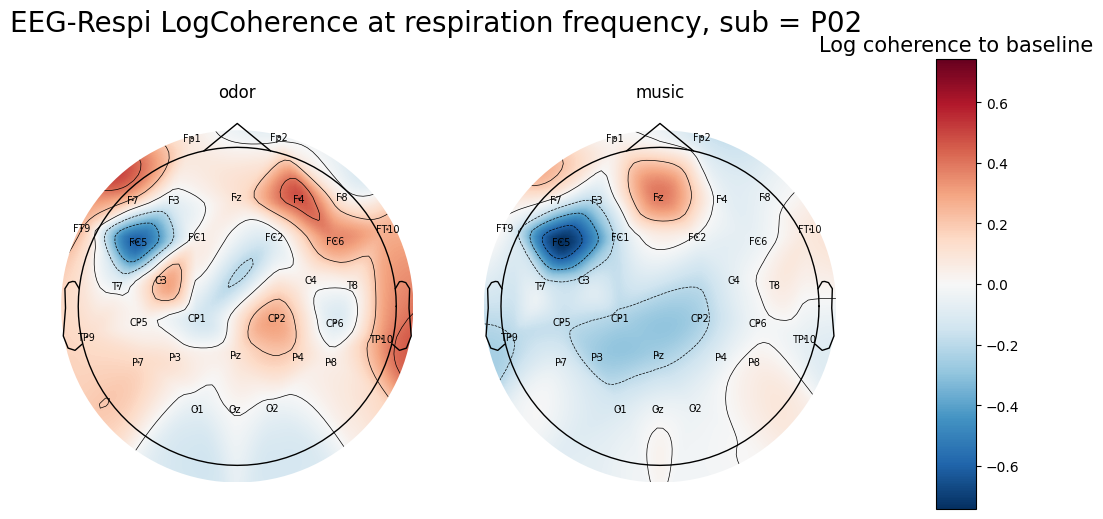

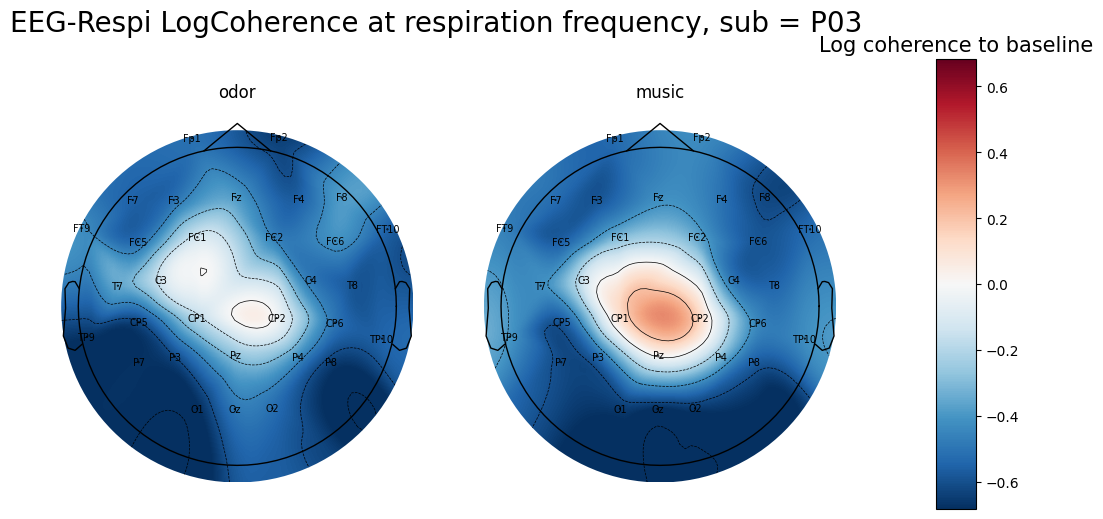

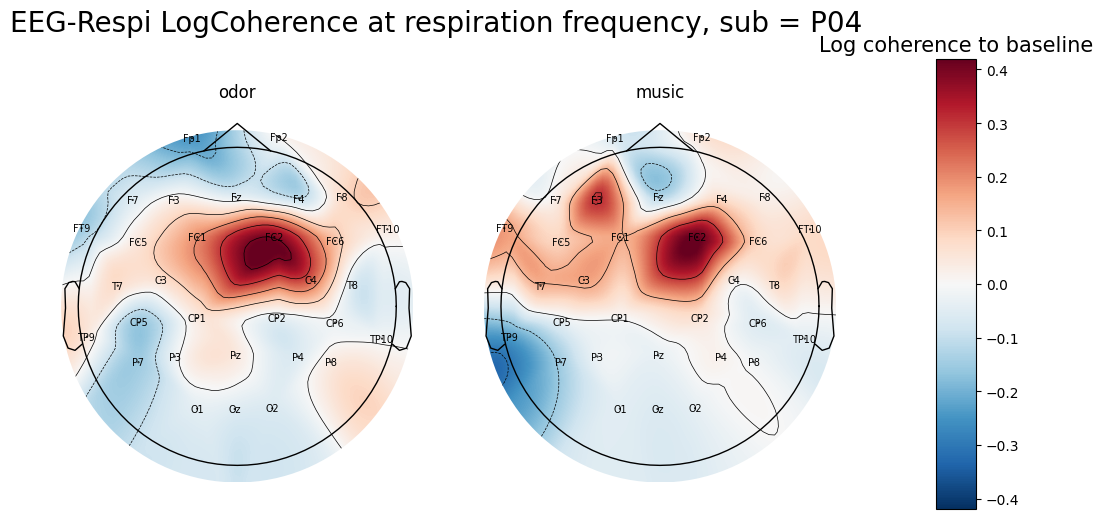

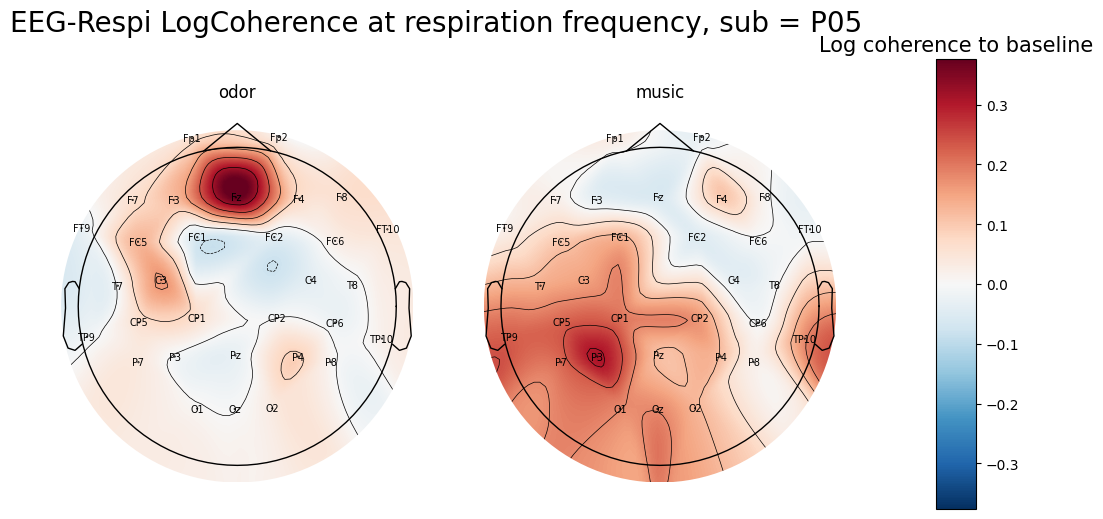

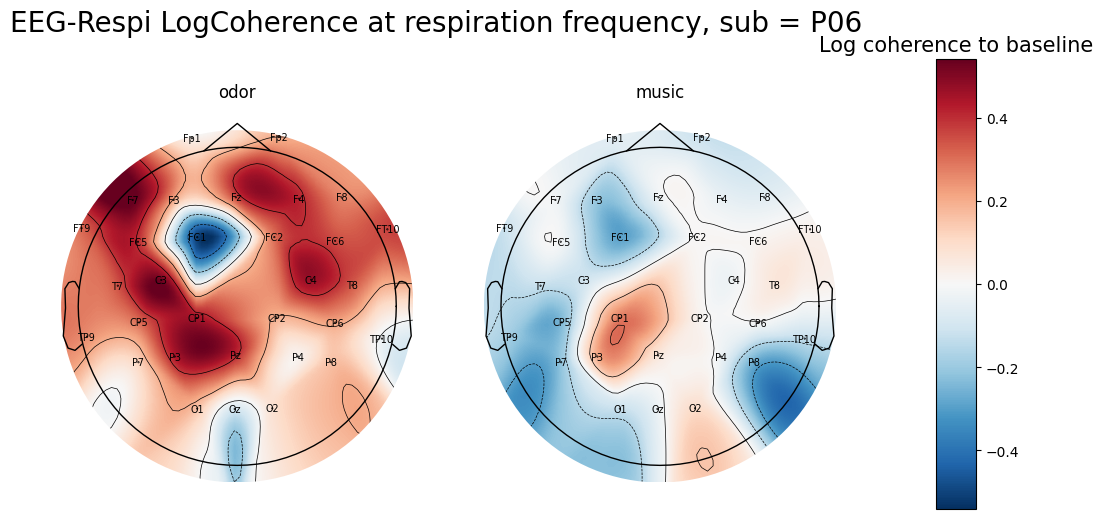

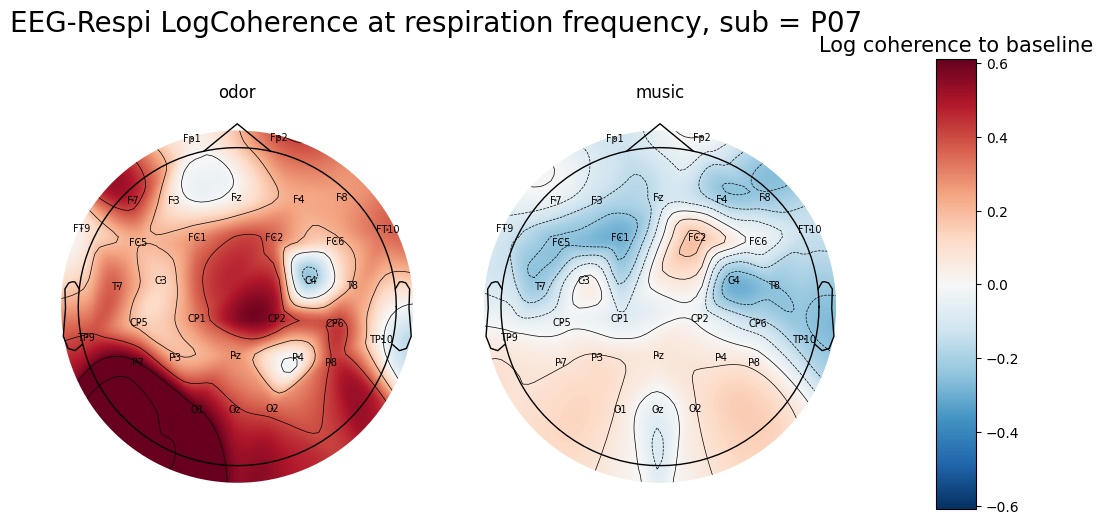

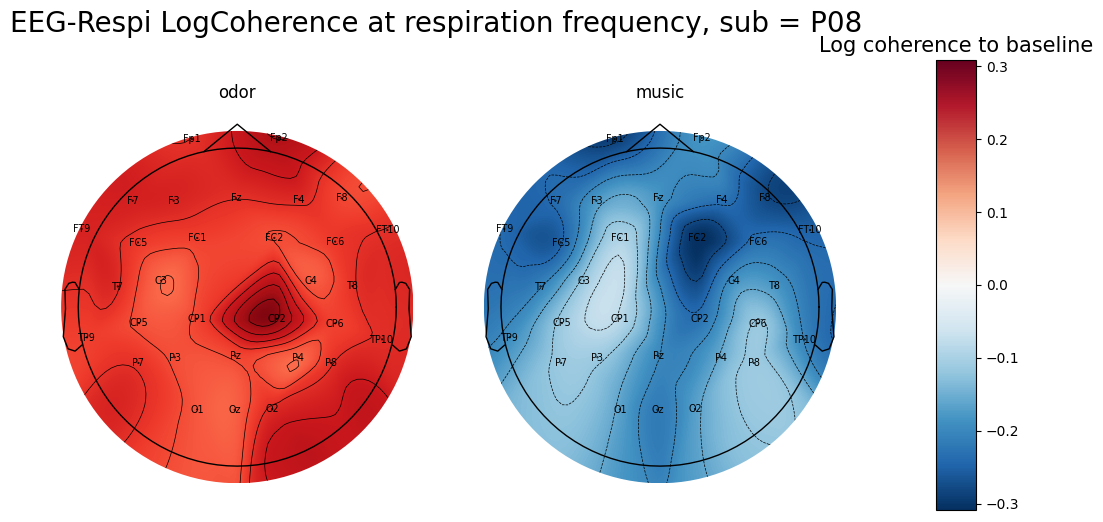

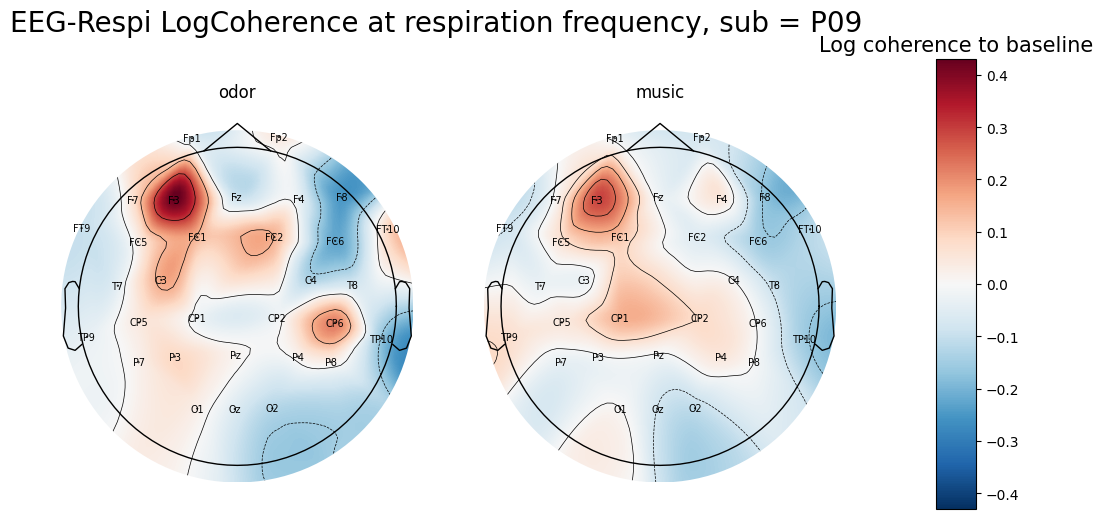

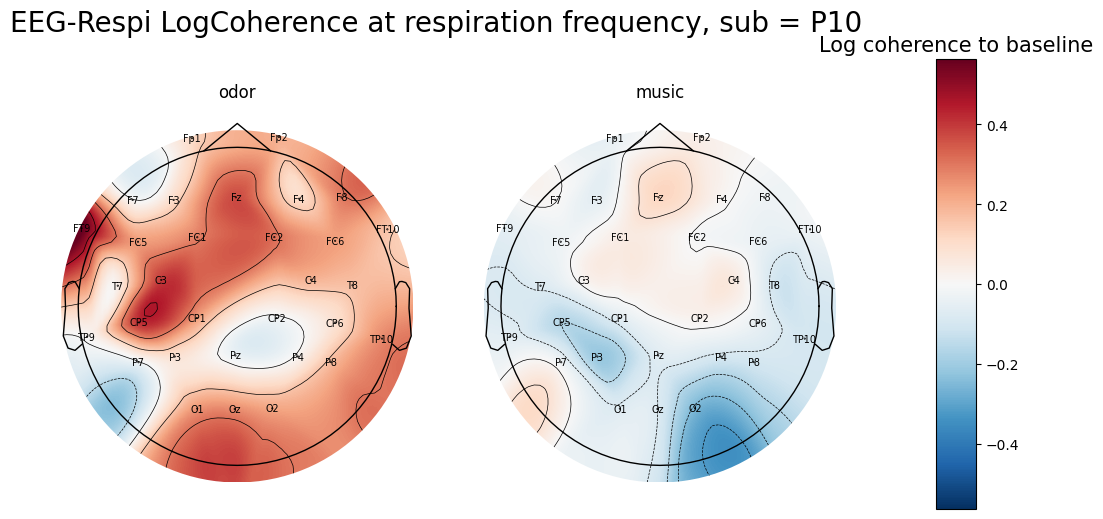

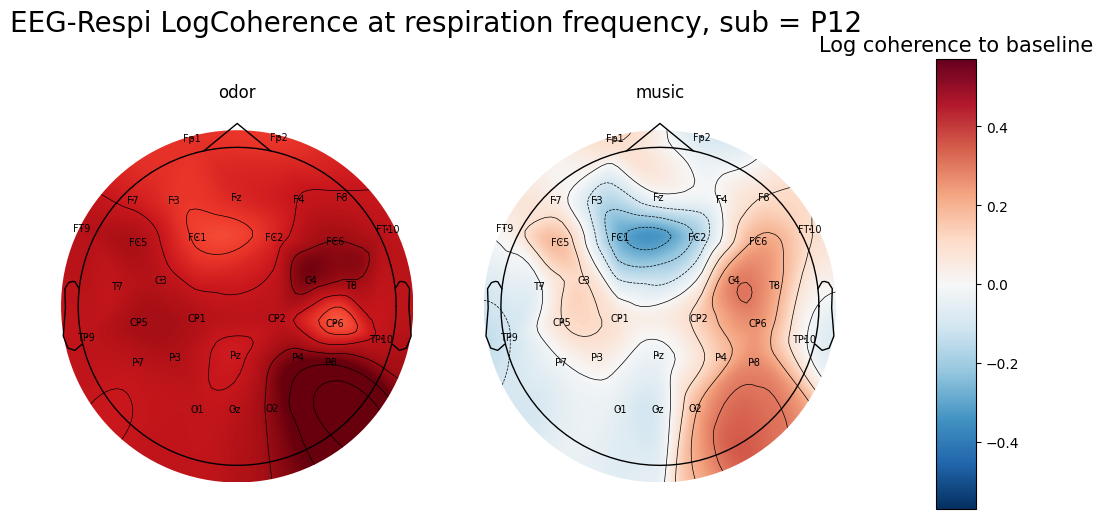

In [12]:
q_diff = 0.

for subject in subject_keys:
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)['max_coherence'].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)['max_coherence'].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Log coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    fig.show()